In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib as mat
import pdcast as pdc
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


In [3]:
test = pd.read_csv("sales_train_validation.csv")
train = pd.read_csv("sales_train_evaluation.csv")
sell_prices = pd.read_csv("sell_prices.csv")
calender = pd.read_csv("calender.csv")
sample_sub = pd.read_csv("sample_submission.csv")

Downcasting the train_dset

We have a huge dataset to work on, and before feeding this dataset into the model, we are going to "Melt" it which would the data fram would be converted from wide format to a long format. I have kept the id variables as id, item_id, dept_id, cat_id, store_id and state_id. They have in total 30490 unique values when compunded together. Now the total number of days for which we have the data is 1969 days. Therefore the melted dataframe will be having 30490x1969 i.e. 60034810 rows.

In order to process to such huge dataset, we would need to reduce the memory usage.

In [4]:
train_d = pdc.downcast(train)
test_d = pdc.downcast(test)
sell_prices_d = pdc.downcast(sell_prices)
calender_d  = pdc.downcast(calender)
sample_sub_d = pdc.downcast(sample_sub)

Checking the difference of original dataset and downcasted dataset

In [6]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


In [7]:
train_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: bool(5), category(5), object(1), uint16(47), uint8(1889)
memory usage: 58.3+ MB


Melting is Performed

In [5]:
df = pd.melt(train_d, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

## So, this dataframe would be used for the further training of the LSTM as well as ARIMA model.

In [6]:
df = pd.merge(df, calender_d, on='d', how='left')
df = pd.merge(df, sell_prices_d, on=['store_id','item_id','wm_yr_wk'], how='left')
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,False,False,False,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,False,False,False,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,False,False,False,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,False,False,False,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,False,False,False,NaN


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59181090 entries, 0 to 59181089
Data columns (total 22 columns):
 #   Column        Dtype   
---  ------        -----   
 0   id            object  
 1   item_id       category
 2   dept_id       category
 3   cat_id        category
 4   store_id      category
 5   state_id      category
 6   d             object  
 7   sold          object  
 8   date          object  
 9   wm_yr_wk      uint16  
 10  weekday       category
 11  wday          uint8   
 12  month         uint8   
 13  year          uint16  
 14  event_name_1  category
 15  event_type_1  category
 16  event_name_2  object  
 17  event_type_2  category
 18  snap_CA       bool    
 19  snap_TX       bool    
 20  snap_WI       bool    
 21  sell_price    float32 
dtypes: bool(3), category(9), float32(1), object(5), uint16(2), uint8(2)
memory usage: 5.9+ GB


# Exploratory Data Analysis -> for checking null values

In [28]:
train_d.isnull().sum().sort_values(ascending = False)

id        0
d_1273    0
d_1301    0
d_1300    0
d_1299    0
         ..
d_639     0
d_638     0
d_637     0
d_636     0
d_1941    0
Length: 1947, dtype: int64

In [29]:
sell_prices.isnull().sum().sort_values(ascending = False)

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

In [30]:
calender_d.isnull().sum().sort_values(ascending = False)

event_name_2    1964
event_type_2    1964
event_name_1    1807
event_type_1    1807
date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

So, I think the columns of calender_d should be dropped...

In [14]:
import plotly.express as px

#for plotting the below graph its very much needed



group = df.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)['sold'].sum().dropna()
group['USA'] = 'United States of America'
group.rename(columns={'state_id':'State','store_id':'Store','cat_id':'Category','dept_id':'Department','item_id':'sold'},inplace=True)

group = group[group['sold']!=0]

#only the code above will remove the zero divivsion error in vscode jupyter extension not to be used in jupyter notebook.

fig = px.treemap(group, path=['USA','State', 'Store', 'Category', 'Department'], values='sold',
                  color='sold',
                  title='Sum of sales across whole USA/different States/Stores/Categories/Departments')
fig.update_layout(template='seaborn')
fig.show()

# Exploratory Data Analysis to prove that Seasonality Exists

In [9]:
#function to plot sales accross different states

def sales(feat,param):
    dataframe_sales_temp = df.loc[df[feat] == param]
    dataframe_sales_temp['date'] = pd.to_datetime(dataframe_sales_temp['date'])
    dataframe_sales_temp =dataframe_sales_temp.groupby('date')['sold'].sum().reset_index()
    dataframe_sales_temp = dataframe_sales_temp.set_index('date')
    return dataframe_sales_temp

C:\Users\sarth\AppData\Local\Temp\ipykernel_11792\4137790735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['date'] = pd.to_datetime(sales_df['date'])


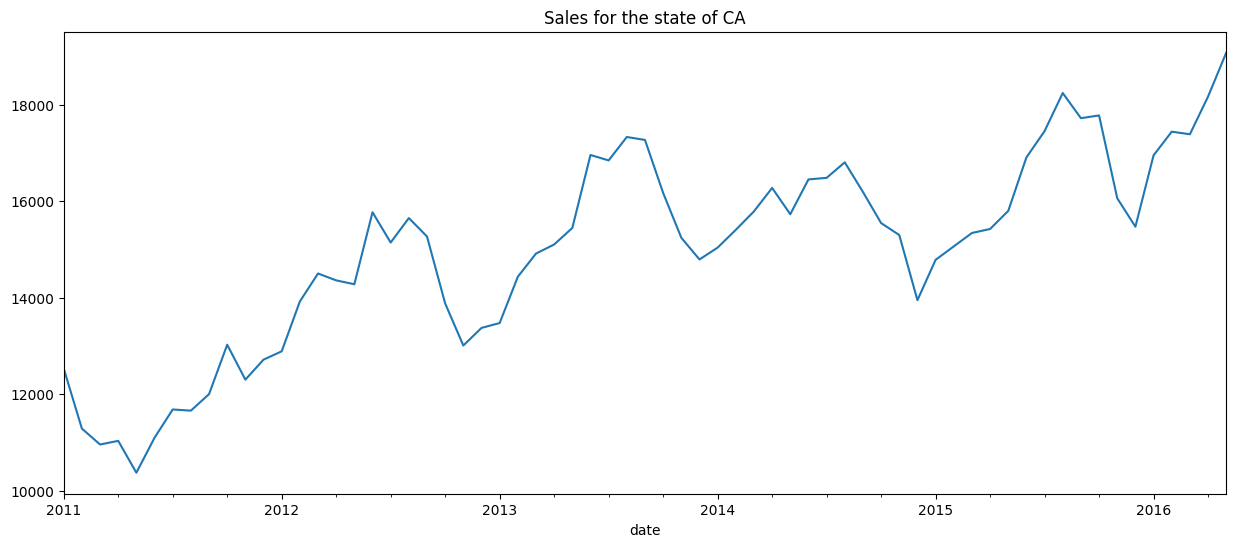

In [11]:
CA = sales("state_id","CA") # create a dataframe for the state of california.
y_ca = CA['sold'].resample('MS').mean() # taking monthly average for the sales and then plotting them to prove seasonality.

y_ca.plot(figsize=(15, 6),color = "blue",title = ("Sales for the state of CA"))
plt.ylabel = ("Sales")
plt.show()

So, from the sbove graph we can conclude that there is an upward trend year on year. Whereas, I can see that there is always dip in sale prices on the start and end of the year which proves that seasonality does exists. So, we can see this trend in the states of Texas and Wisconsin.

In [14]:
from itertools import cycle, islice
import statsmodels.api as sm
from pylab import rcParams
def decompose(y):
    rcParams['figure.figsize'] = 18, 8
    decomposition = sm.tsa.seasonal_decompose(y, model='additive')
    fig = decomposition.plot()
    plt.show()

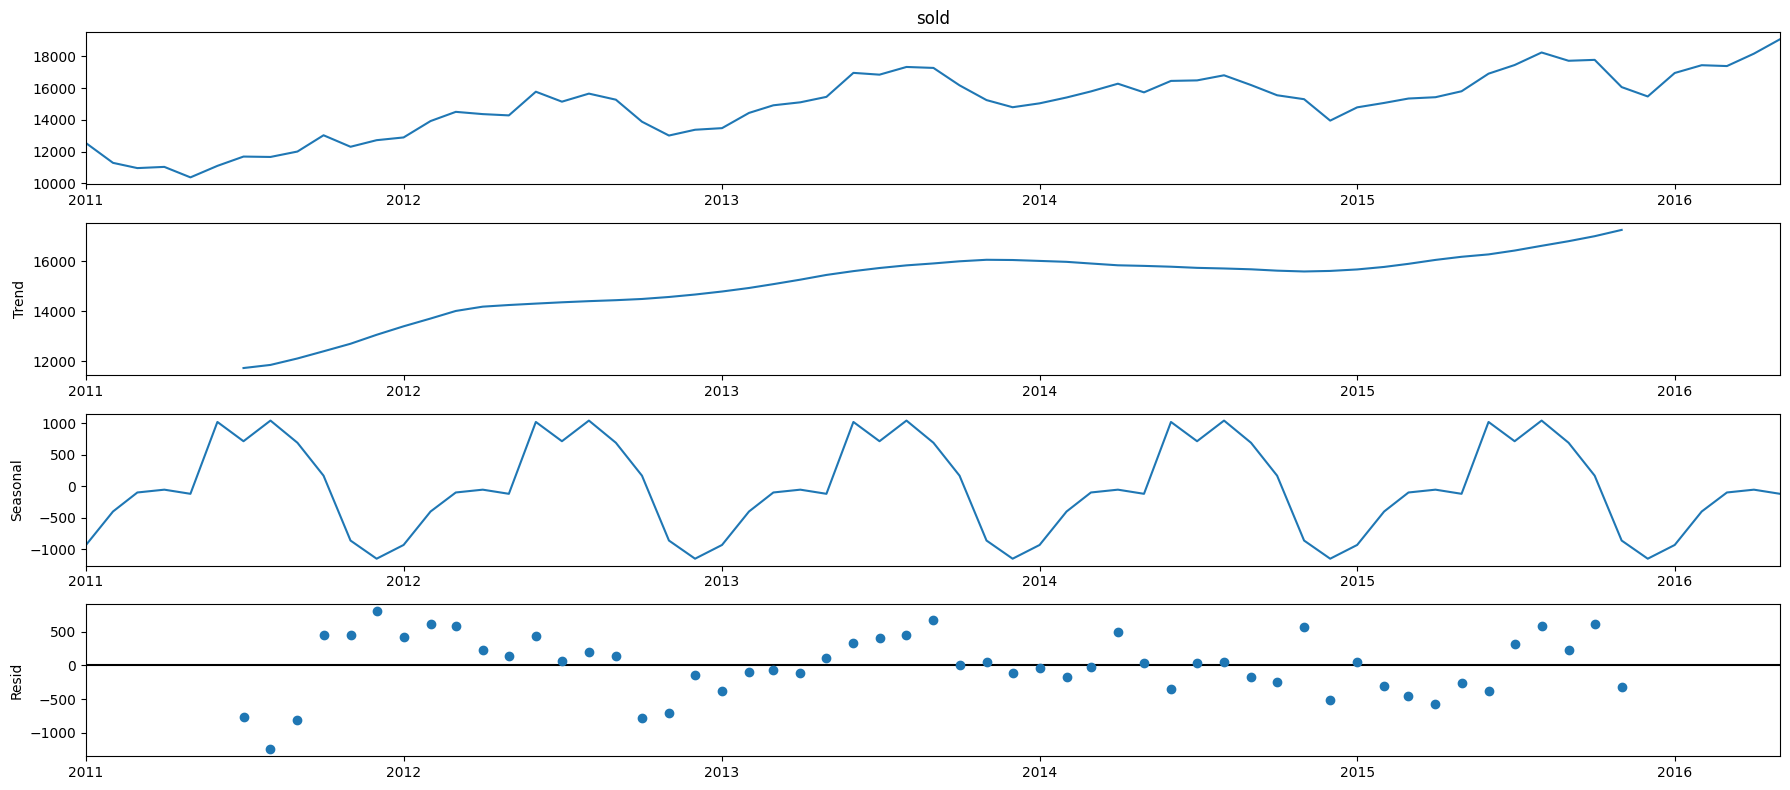

In [15]:
decompose(y_ca)

C:\Users\sarth\AppData\Local\Temp\ipykernel_11792\4137790735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['date'] = pd.to_datetime(sales_df['date'])


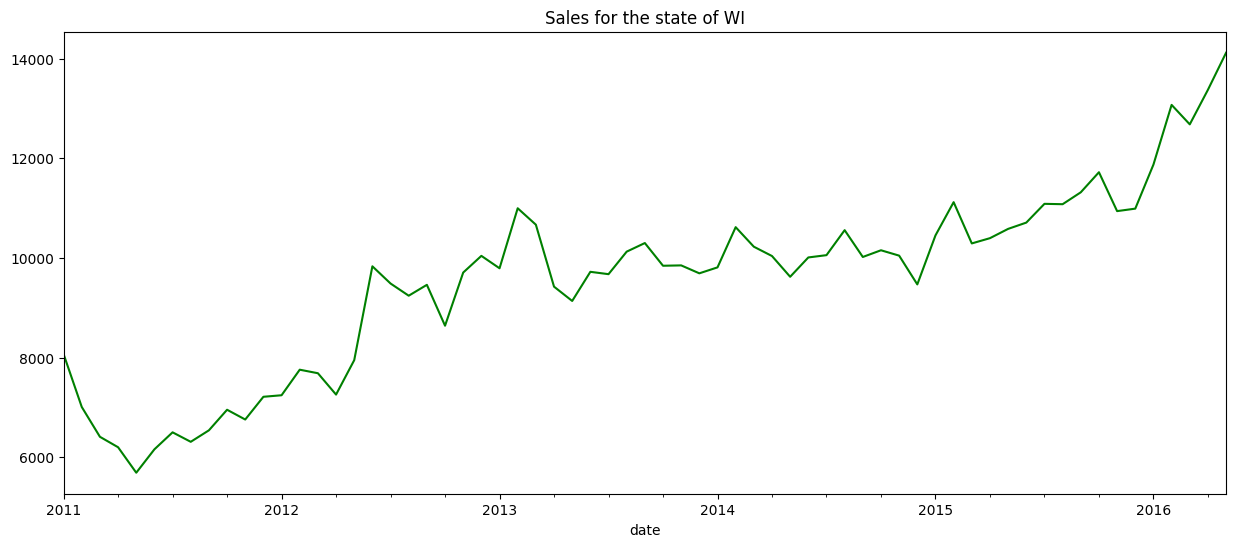

In [17]:
WI = sales("state_id","WI")
y_wi = WI['sold'].resample('MS').mean()

y_wi.plot(figsize=(15, 6),color = "green",title = ("Sales for the state of WI"))
plt.ylabel = ("Sales")
plt.show()

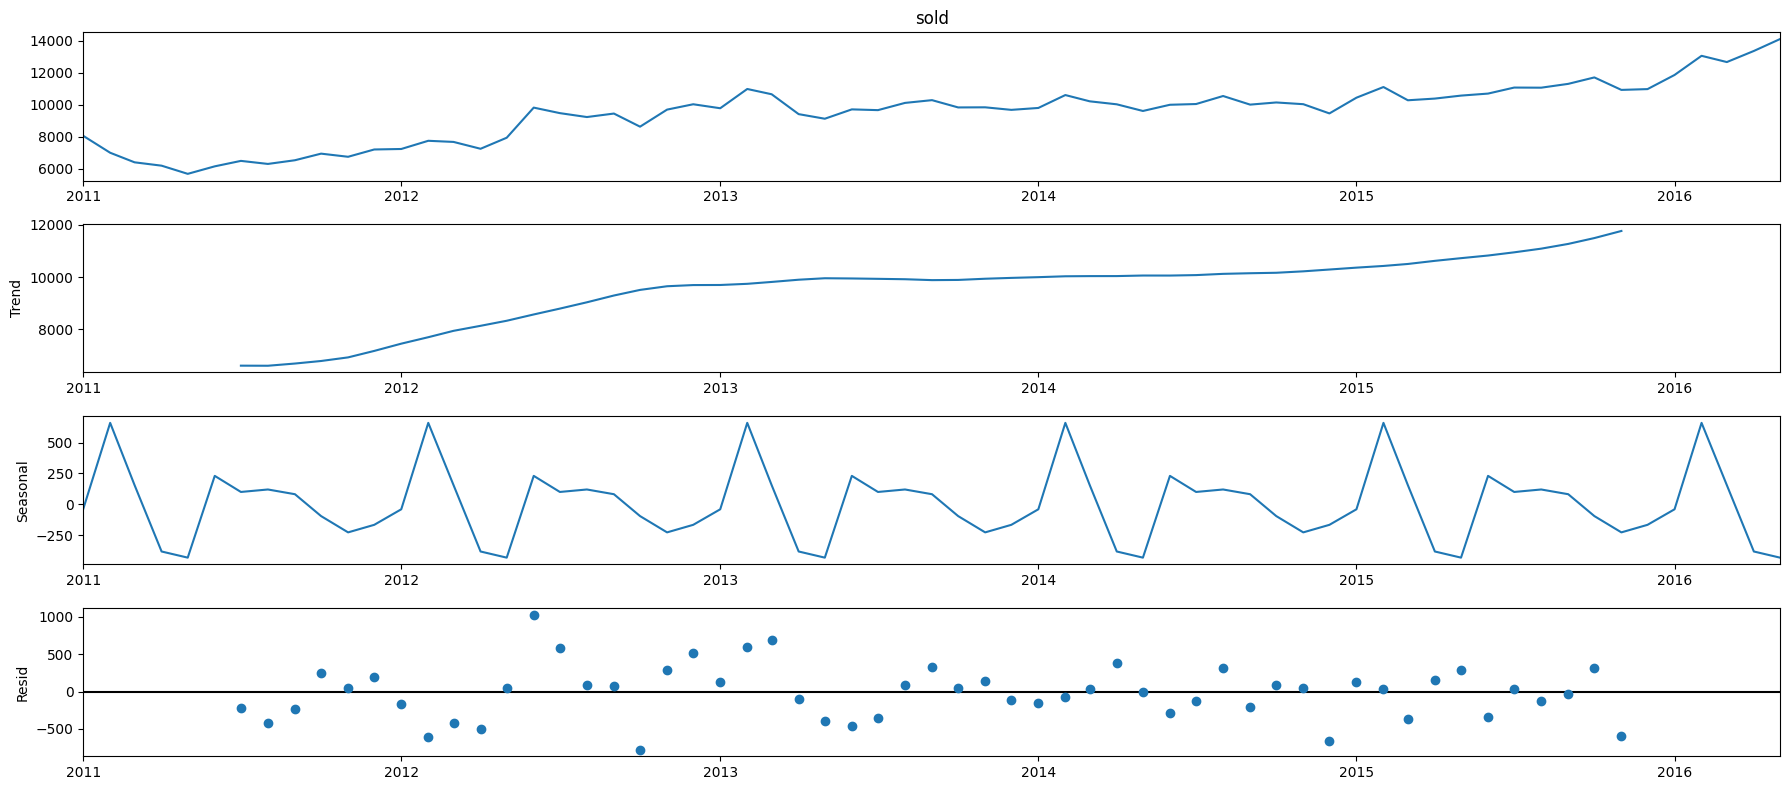

In [20]:
decompose(y_wi)

C:\Users\sarth\AppData\Local\Temp\ipykernel_11792\4137790735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['date'] = pd.to_datetime(sales_df['date'])


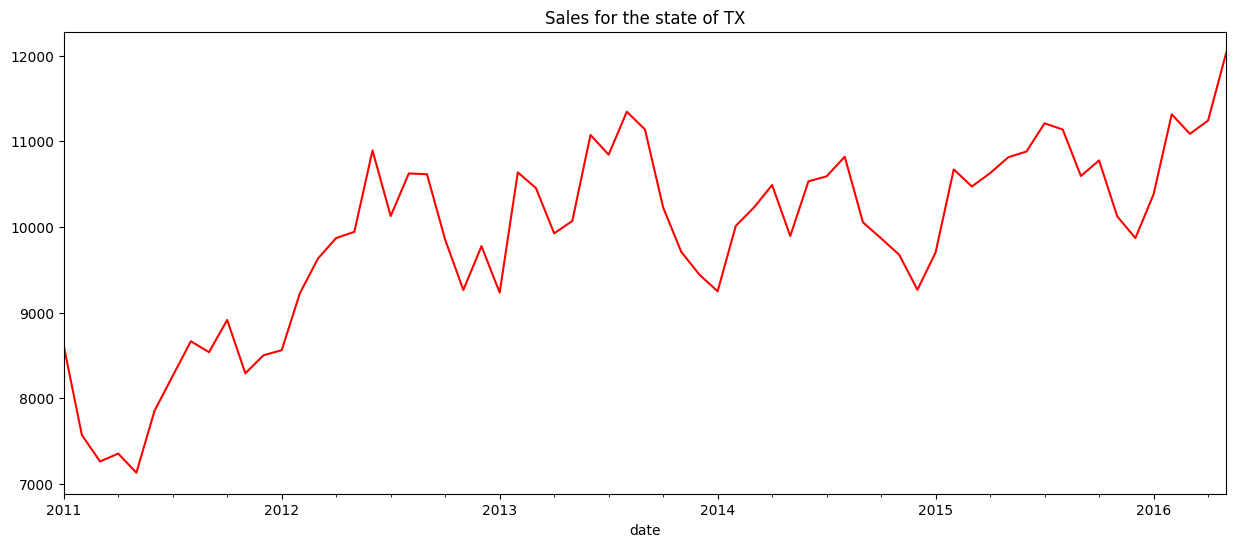

In [21]:
TX = sales("state_id","TX")
y_tx = TX['sold'].resample('MS').mean()

y_tx.plot(figsize=(15, 6),color = "red",title = ("Sales for the state of TX"))
plt.show()

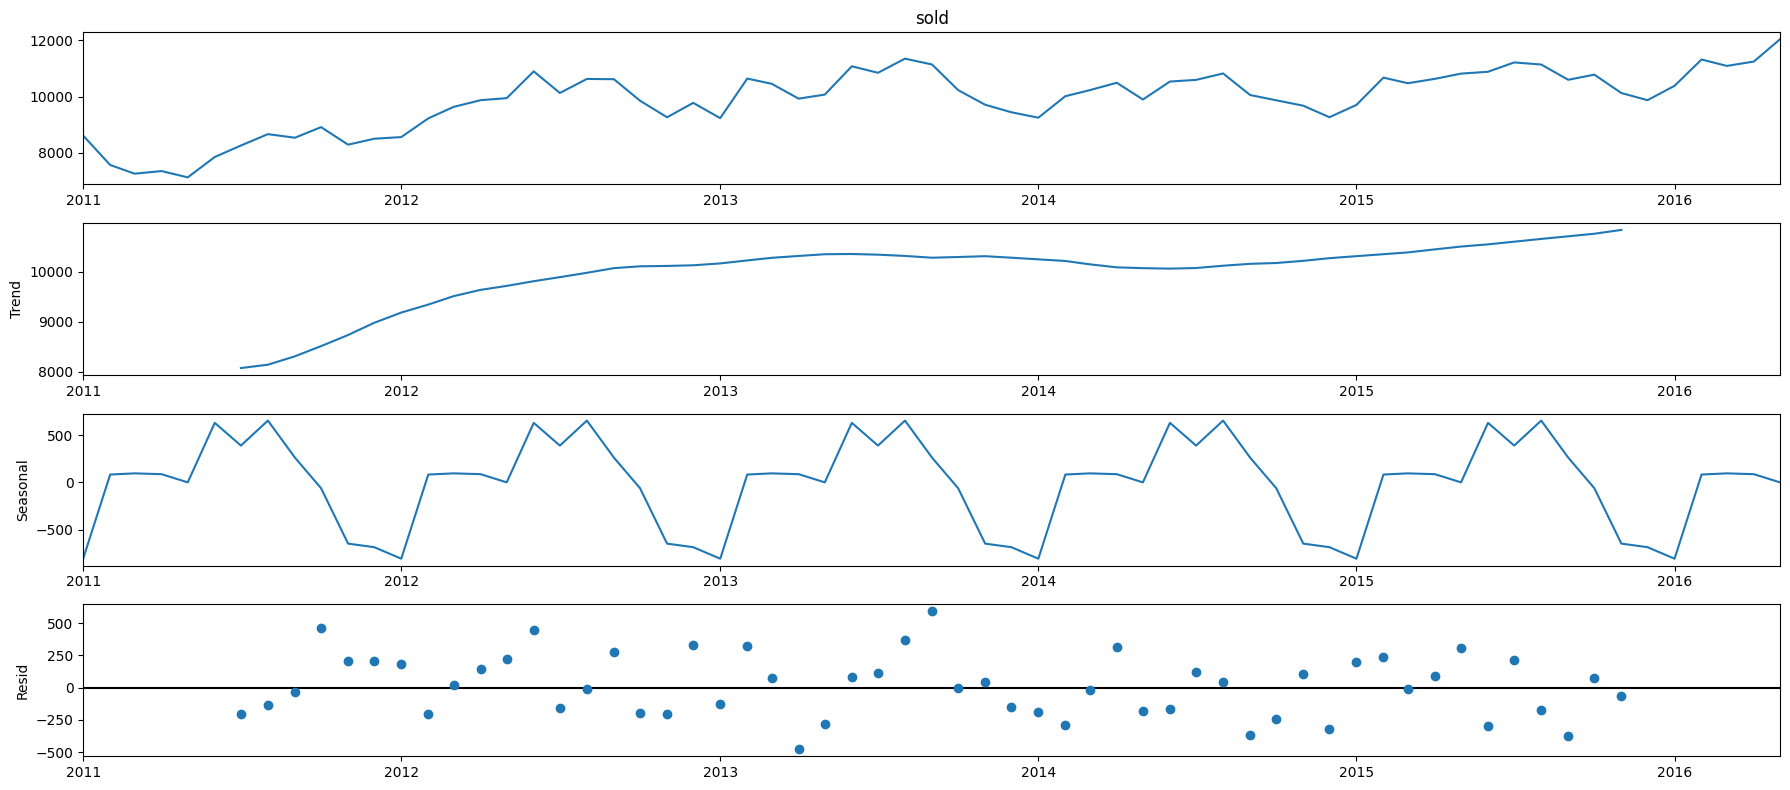

In [22]:
decompose(y_tx)

In [23]:
import gc
del CA,WI,TX
gc.collect()

55103

# LSTM Model Training without External Parameters

In [5]:
final_df = pd.read_csv("tableau_sales_train_evaluation_365_days.csv")#assigning the dataframe for this model's creation with the merged files.

In [6]:
final_df = final_df.T

In [7]:
final_df = final_df[6:]

In [8]:
final_df

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
d_1,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
d_3,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
d_4,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
d_5,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_361,0,0,0,3,0,0,0,9,1,1,...,0,11,1,0,4,0,0,0,0,0
d_362,0,1,0,0,0,0,0,14,0,3,...,0,4,1,0,3,0,0,1,0,0
d_363,0,1,0,1,0,0,0,0,0,1,...,0,1,1,0,3,0,0,0,0,0
d_364,0,0,0,2,0,0,0,8,3,1,...,0,5,2,0,7,0,0,0,0,0


In [9]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
final_df = sc.fit_transform(final_df)

In [31]:
timesteps=10
X_train = []
y_train = []
for i in range(timesteps, 365):
    X_train.append(final_df[i-timesteps:i])
    y_train.append(final_df[i][0:30490])

In [32]:
X_train = np.array(X_train, dtype = 'float16')
y_train = np.array(y_train, dtype = 'float16')

In [33]:
X_train.shape,y_train.shape

((355, 10, 30490), (355, 30490))

In [34]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units =64,input_shape = (np.array(X_train).shape[1], np.array(X_train).shape[2])))
model.add(tf.keras.layers.Dense(30490))

model.compile(
  loss='mean_squared_error',
  optimizer=tf.keras.optimizers.Adam(0.001)
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                7822080   
                                                                 
 dense_1 (Dense)             (None, 30490)             1981850   
                                                                 
Total params: 9,803,930
Trainable params: 9,803,930
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(X_train, y_train, epochs = 10, batch_size = 10)

Epoch 1/10
36/36 [==============================] - 5s 95ms/step - loss: 0.0179
Epoch 2/10
36/36 [==============================] - 3s 81ms/step - loss: 0.0159
Epoch 3/10
36/36 [==============================] - 3s 84ms/step - loss: 0.0158
Epoch 4/10
36/36 [==============================] - 3s 80ms/step - loss: 0.0158
Epoch 5/10
36/36 [==============================] - 3s 80ms/step - loss: 0.0154
Epoch 6/10
36/36 [==============================] - 3s 81ms/step - loss: 0.0150
Epoch 7/10
36/36 [==============================] - 3s 81ms/step - loss: 0.0147
Epoch 8/10
36/36 [==============================] - 3s 82ms/step - loss: 0.0144
Epoch 9/10
36/36 [==============================] - 3s 83ms/step - loss: 0.0143
Epoch 10/10
36/36 [==============================] - 3s 86ms/step - loss: 0.0141
